# Data Loading

In [ ]:
#prod
#Imports and Installs, uncomment the install for first run
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

In [ ]:
#prod
#Data stored in Google Drive, must authenticate to pull data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#prod
#01_M02_DC_train
#https://drive.google.com/file/d/1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2'})
fileDownloaded.GetContentFile('01_M02_DC_train.csv')

#01_M02_train_fault_data
#https://drive.google.com/file/d/1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV'})
fileDownloaded.GetContentFile('01_M02_train_fault_data.csv')

#01_M02_DC_train_ttf
#https://drive.google.com/file/d/1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU'})
fileDownloaded.GetContentFile('01_M02_DC_train_ttf.csv')

#loading into CSVs
df_train = pd.read_csv('01_M02_DC_train.csv', delimiter=',')
df_train.set_index('time')

df_fault = pd.read_csv('01_M02_train_fault_data.csv', delimiter=',')
df_fault.set_index('time')

df_ttf = pd.read_csv('01_M02_DC_train_ttf.csv', delimiter=',')
df_ttf.set_index('time')


# #03_M02_DC_train
# #https://drive.google.com/file/d/1Mho3WwCHX5JUo5IZwibV5MNBvJr_ZRhJ/view?usp=share_link
# fileDownloaded = drive.CreateFile({'id':'1Mho3WwCHX5JUo5IZwibV5MNBvJr_ZRhJ'})
# fileDownloaded.GetContentFile('03_M02_DC_train.csv')

# #03_M02_train_fault_data
# #https://drive.google.com/file/d/1-uZaGxkZBF-wrg5mBIL1WIL187Bc_cUt/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1-uZaGxkZBF-wrg5mBIL1WIL187Bc_cUt'})
# fileDownloaded.GetContentFile('03_M02_train_fault_data.csv')

# #03_M02_DC_train_ttf
# #https://drive.google.com/file/d/1IpBcjBap0LCVqKLb2Uwk3biTuXlpB4qF/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1IpBcjBap0LCVqKLb2Uwk3biTuXlpB4qF'})
# fileDownloaded.GetContentFile('03_M02_DC_train_ttf.csv')

# #loading into CSVs
# df_train = pd.read_csv('03_M02_DC_train.csv', delimiter=',')
# df_train.set_index('time')

# df_fault = pd.read_csv('03_M02_train_fault_data.csv', delimiter=',')
# df_fault.set_index('time')

# df_ttf = pd.read_csv('03_M02_DC_train_ttf.csv', delimiter=',')
# df_ttf.set_index('time')

# Preprocessing

In [ ]:
#prod
#Make sure the TTFs are all divisible by 4, and subtract mod 4 if not
df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] = df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].sub(df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] % 4)
df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] = df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].sub(df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] % 4)
df_ttf['TTF_Flowcool leak'] = df_ttf['TTF_Flowcool leak'].sub(df_ttf['TTF_Flowcool leak'] % 4)

#set failure time to mod 4 as well so the time index matches other datasets
df_fault['time'] = df_fault['time'].sub(df_fault['time'] % 4)

# #sanity check
# print(df_ttf.loc[df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].isin([1, 2, 3])])
# print(df_ttf.loc[df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].isin([1, 2, 3])])
# print(df_ttf.loc[df_ttf['TTF_Flowcool leak'].isin([1, 2, 3])])

#join the ttf and training data together on time
df = pd.concat([df_train, df_ttf], axis=1, join = 'inner')
df.columns = ['time', 'Tool', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step','IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK','FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE','FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION', 'time_drop','TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump','TTF_Flowcool leak']
#drop excess "time" column by position
df = df.drop(df.columns[24],axis = 1)

#FSP of 1 is the only important data
df = df.loc[df['FIXTURESHUTTERPOSITION'] == 1]
#drop NaNs that are present at the end of ttf (no more failures)
df = df.dropna(subset=['TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak'], how='all')
#drop duplicates ignoring the time and TTF columns
df.drop_duplicates(subset=df.columns.difference(['time', 'TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump',	'TTF_Flowcool leak']))

#Make 3 dataframes, one for each fail type
df_f1 = df.drop(['TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f1 = df_f1.dropna()
df_f2 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit',          'TTF_Flowcool leak', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f2 = df_f2.dropna()
df_f3 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f3 = df_f3.dropna()

#stage, recipe, and recipe step are categorical and need to be encoded as such, but adds complexity. Wu dropped them. include OHE in Proprocess_data function

In [ ]:
#prod
def PreProcess_Data(df_f1, df_f2, df_f3, numKept, numFail):
    #only keep the data within 6000 seconds of a failure  to closer analyze the data
    df_f1 = df_f1.loc[df['TTF_FlowCool Pressure Dropped Below Limit'] < numKept]
    df_f2 = df_f2.loc[df['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numKept]
    df_f3 = df_f3.loc[df['TTF_Flowcool leak'] < numKept]

    # df_f1['IsFailure'] = np.where(df_f1['TTF_FlowCool Pressure Dropped Below Limit'] < numFail, True, False)
    # df_f2['IsFailure'] = np.where(df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numFail, True, False)
    # df_f3['IsFailure'] = np.where(df_f3['TTF_Flowcool leak'] < numFail, True, False)
    df_f1.loc[df_f1['TTF_FlowCool Pressure Dropped Below Limit'] < numFail, 'IsFailure'] = 1
    df_f1.loc[df_f1['TTF_FlowCool Pressure Dropped Below Limit'] >= numFail, 'IsFailure'] = 0

    df_f2.loc[df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numFail, 'IsFailure'] = 0
    df_f2.loc[df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] > numFail, 'IsFailure'] = 1

    df_f3.loc[df_f3['TTF_Flowcool leak'] < numFail, 'IsFailure'] = 0
    df_f3.loc[df_f3['TTF_Flowcool leak'] > numFail, 'IsFailure'] = 1

    return df_f1, df_f2, df_f3

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
#get data with 5000 points from 0 as relevant and 250 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 5000, 250)

#drop categorical columns
df_temp = df1[['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure']]
df1 = df1.drop(['stage', 'recipe', 'recipe_step', 'Lot', 'runnum', 'TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, columns = df1.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df1_scaled = pd.concat([df1_scaled, df_index], axis=1, join = 'inner')
df1_scaled = df1_scaled.set_index(0)
df1_scaled = pd.concat([df1_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df1_scaled.index[df1_scaled['TTF_FlowCool Pressure Dropped Below Limit'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df1_scaled.loc[zero_index[-3] : zero_index[-2]]

#train data is all data until the third to last 0
df_stream_train = df1_scaled.loc[:zero_index[-3]]

df_stream_xTrain = df_stream_train.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
oversample = SMOTE()
df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_FlowCool Pressure Dropped Below Limit'] > df_stream['TTF_FlowCool Pressure Dropped Below Limit'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

# EDA

In [ ]:
df1_eda = df1_scaled.reset_index()
df1_eda_vis = df1_eda.drop(['index', 'TTF_FlowCool Pressure Dropped Below Limit'], axis=1)
df1_eda_tar = df1_eda['TTF_FlowCool Pressure Dropped Below Limit']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

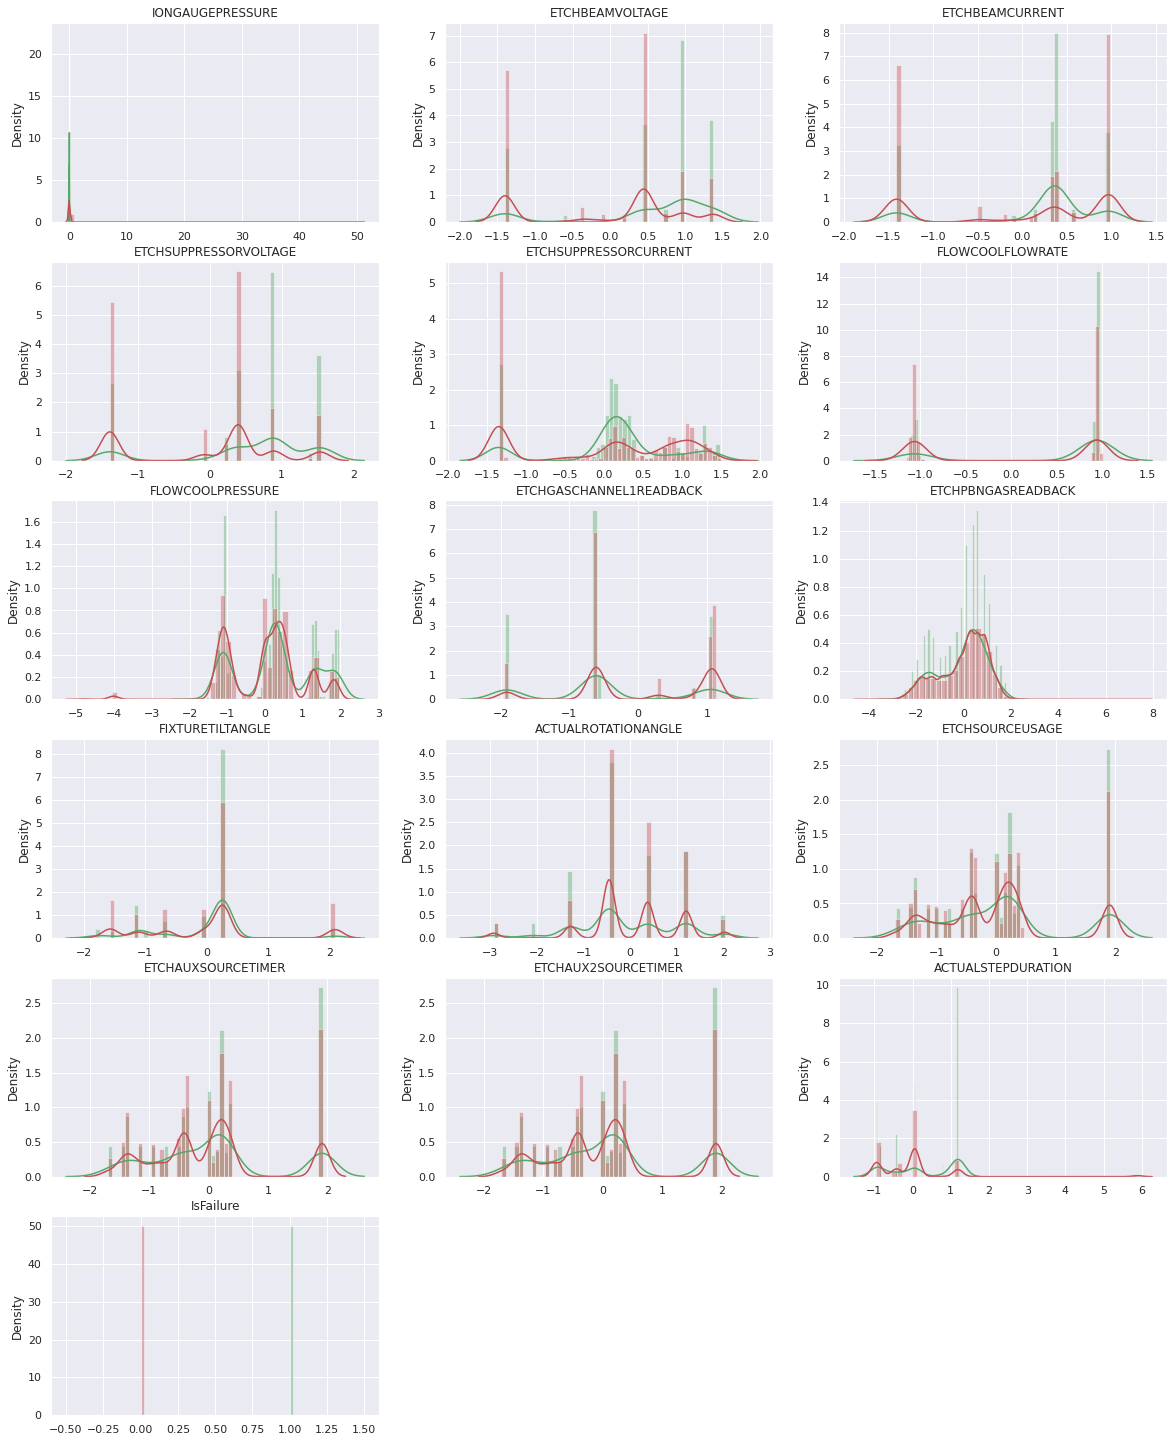

In [ ]:
import matplotlib.gridspec as gridspec
columns =df1_eda_vis.columns
grid = gridspec.GridSpec(7, 3)

plt.figure(figsize=(20,30))

for n, col in enumerate(df1_eda_vis[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df1_eda_vis[df1_eda_vis.IsFailure==1][col], bins = 50, color='g')
    sns.distplot(df1_eda_vis[df1_eda_vis.IsFailure==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

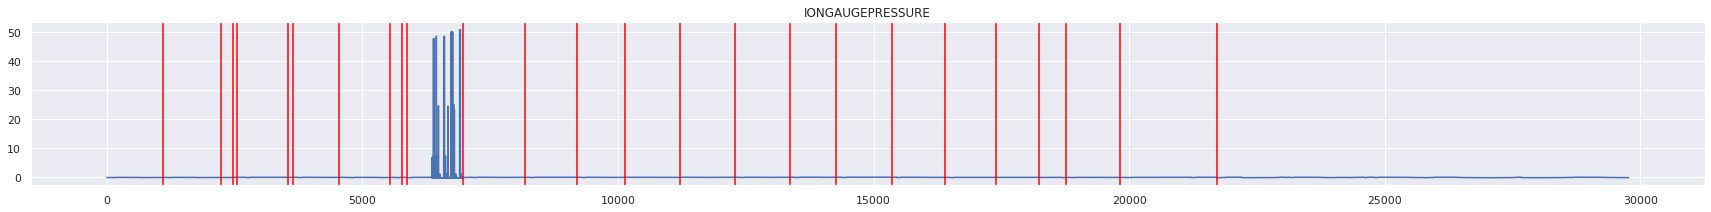

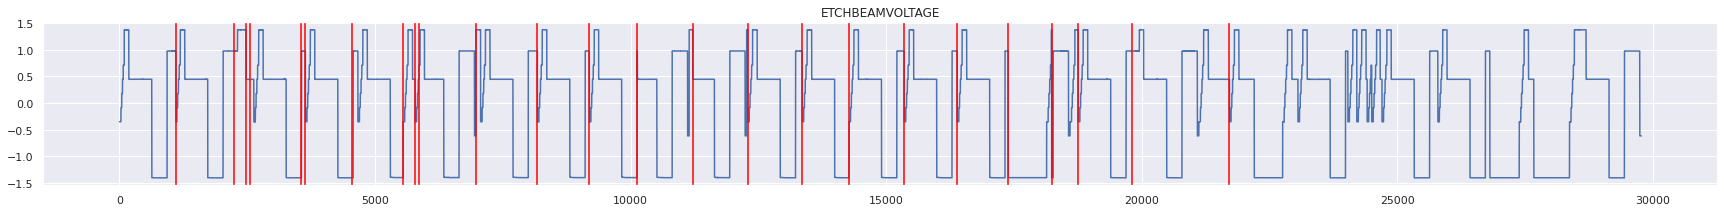

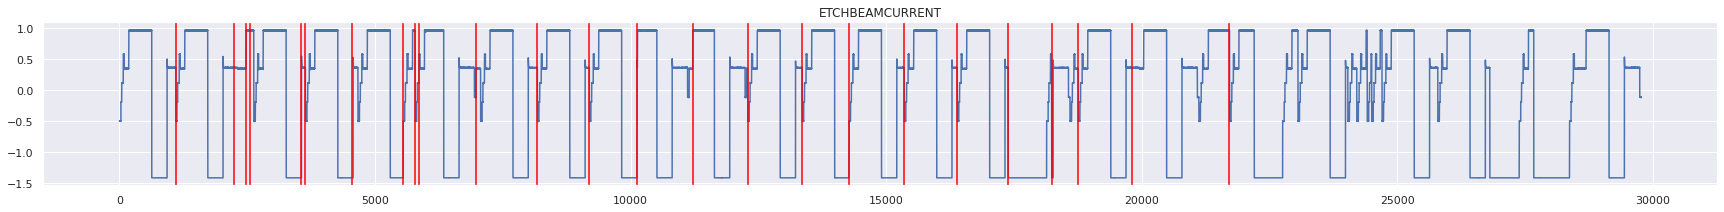

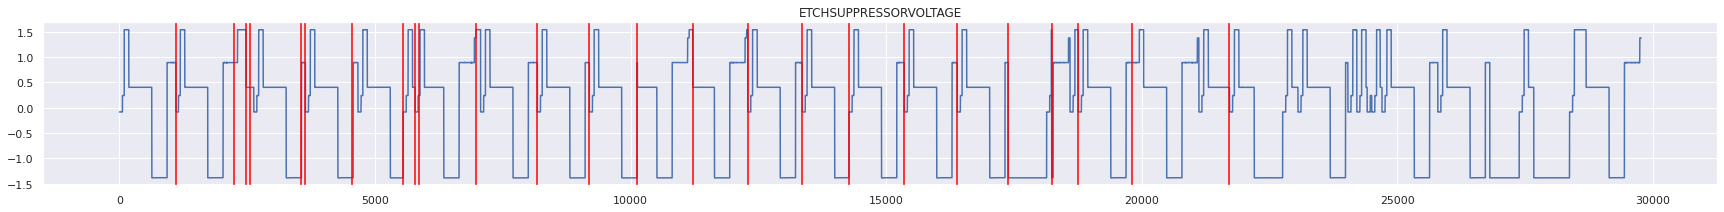

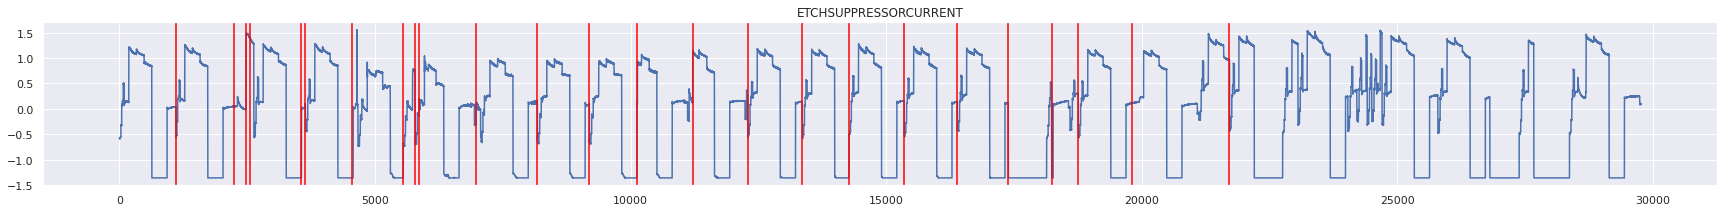

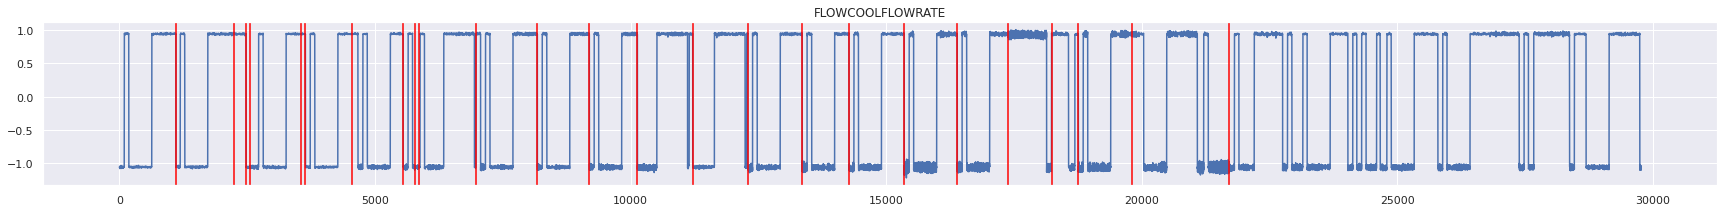

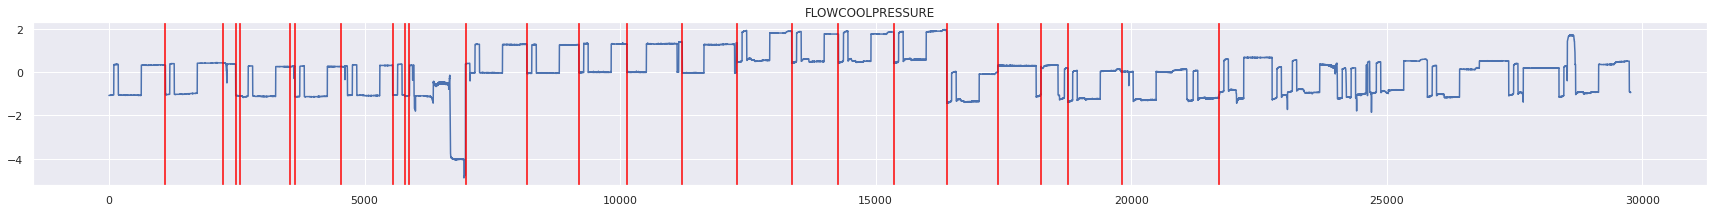

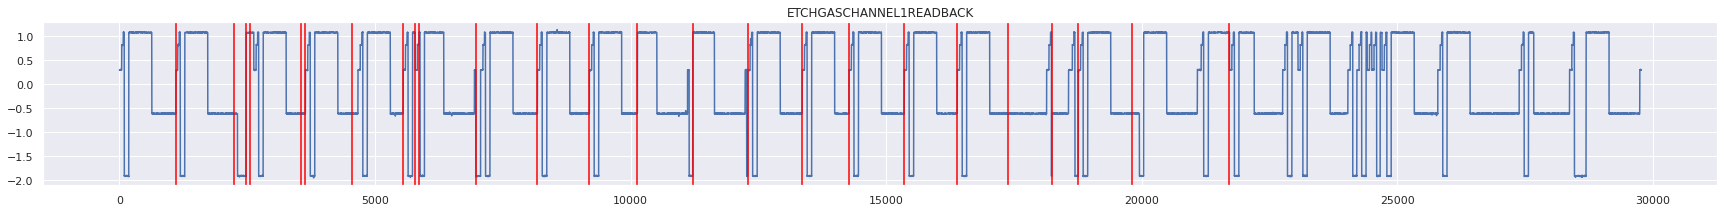

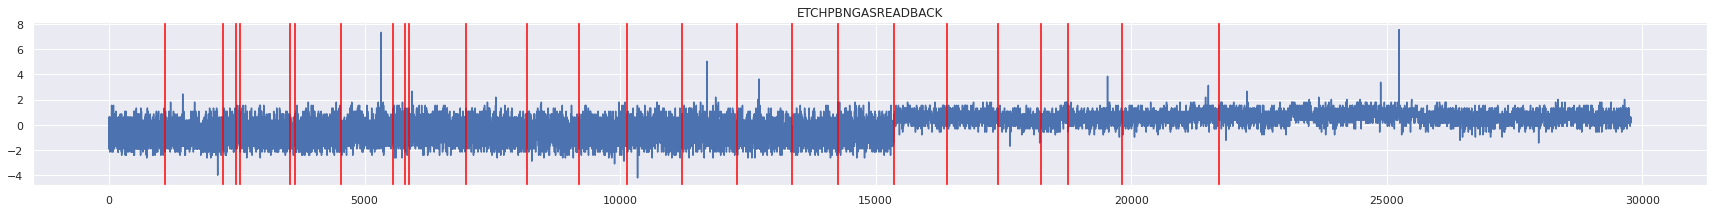

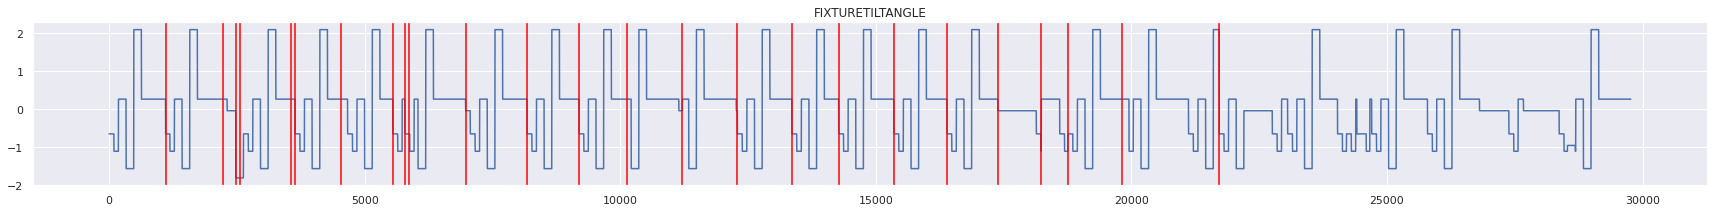

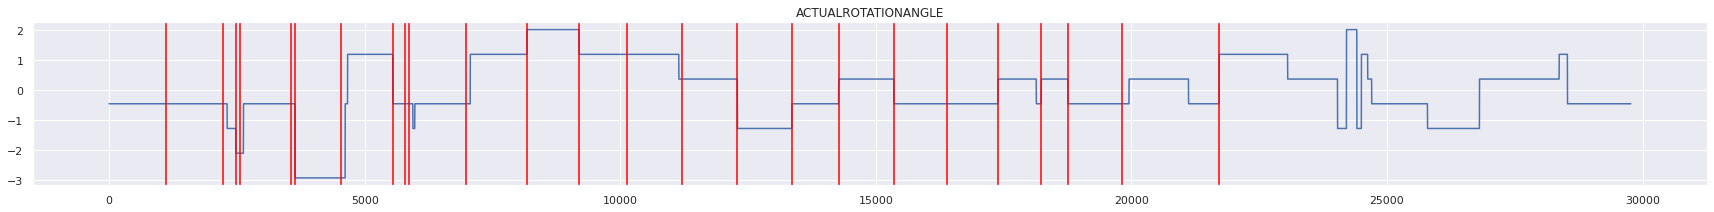

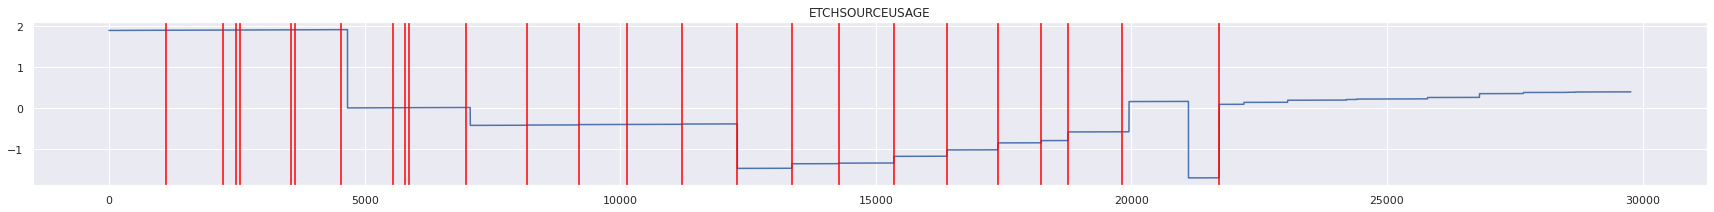

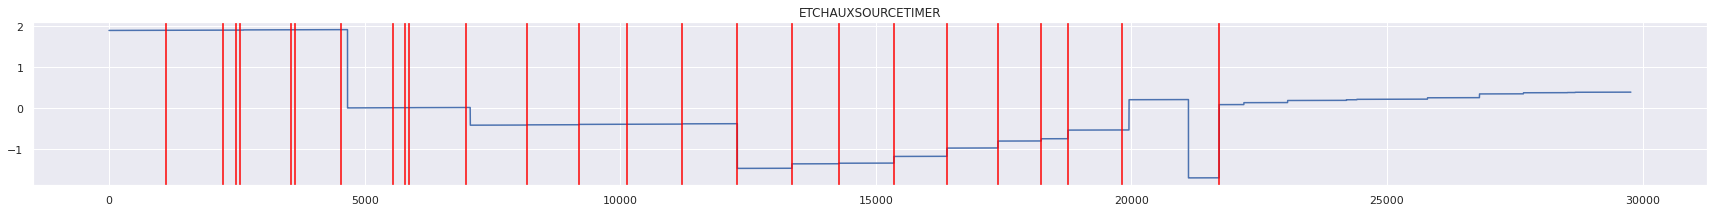

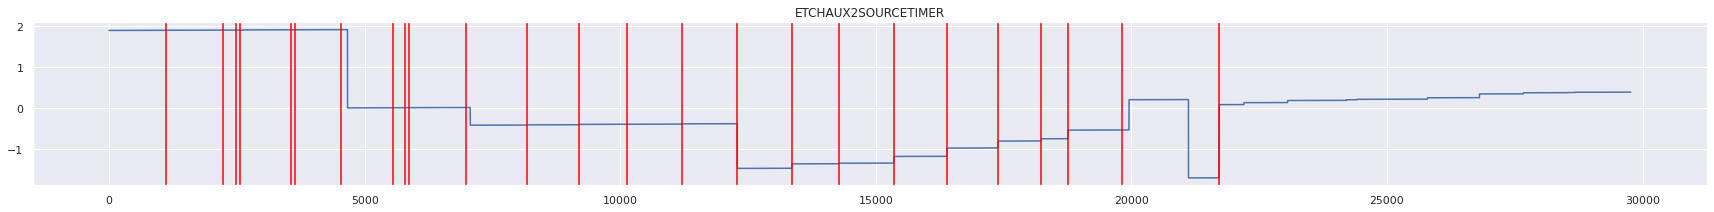

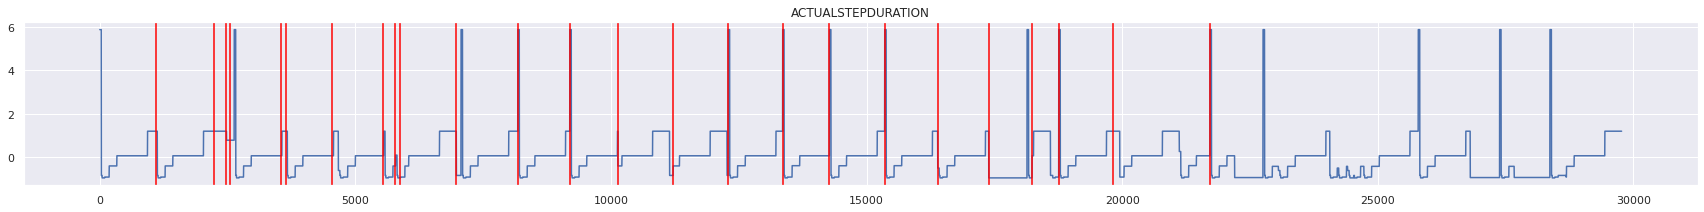

In [ ]:
for column in df1_eda_vis.columns:
    plt.figure(figsize = (30, 3))
    plt.plot(df1_eda_vis.index, df1_eda_vis[column])
    plt.title(column)
    for ele in np.where(df1_eda_tar == 0)[0]:
        plt.axvline(x = ele, color = 'red')

    plt.show()

In [ ]:
df1_eda_vis.describe().apply(lambda s: s.apply('{0:.5f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
IONGAUGEPRESSURE,29772.00000,-0.00000,1.00002,-0.19375,-0.05563,-0.01183,0.01918,50.92982
ETCHBEAMVOLTAGE,29772.00000,0.00000,1.00002,-1.40256,-1.39757,0.44413,0.44571,1.37458
ETCHBEAMCURRENT,29772.00000,-0.00000,1.00002,-1.41227,-1.41083,0.36353,0.96638,0.98170
ETCHSUPPRESSORVOLTAGE,29772.00000,-0.00000,1.00002,-1.38658,-1.38337,0.40337,0.40431,1.54316
ETCHSUPPRESSORCURRENT,29772.00000,0.00000,1.00002,-1.35684,-1.35684,0.16650,0.90046,1.55812
FLOWCOOLFLOWRATE,29772.00000,0.00000,1.00002,-1.22240,-1.05986,0.91612,0.93949,1.00497
FLOWCOOLPRESSURE,29772.00000,-0.00000,1.00002,-4.88970,-0.99764,0.18786,0.51875,1.97078
ETCHGASCHANNEL1READBACK,29772.00000,0.00000,1.00002,-1.95100,-0.61548,-0.60227,1.07208,1.13469
ETCHPBNGASREADBACK,29772.00000,-0.00000,1.00002,-4.24653,-0.59643,0.34264,0.84891,7.56934
FIXTURETILTANGLE,29772.00000,-0.00000,1.00002,-1.81664,-0.65599,0.26032,0.26032,2.09293


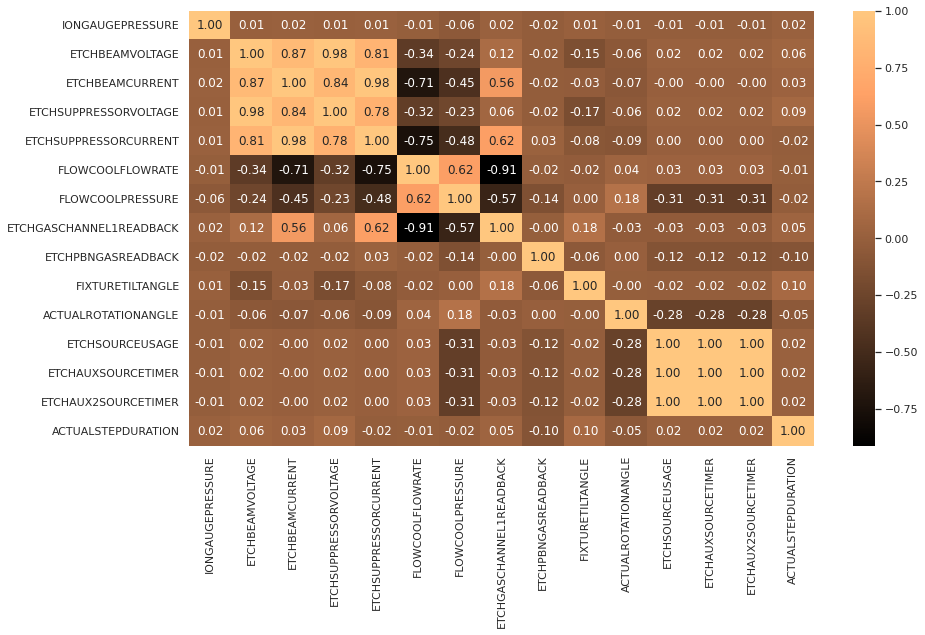

In [ ]:
import seaborn as sns
sns.set()

plt.figure(figsize=(14,8))
sns.heatmap(df1_eda_vis.corr(), annot=True, cmap ='copper', fmt='.2f')
plt.show()